In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from collections import OrderedDict
from time import time

import numpy as np
import scipy as sp
import pandas as pd

from scipy.optimize import fmin_powell
from scipy import integrate
from scipy import linalg

from sklearn.preprocessing import normalize
from sklearn import linear_model
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

np.set_printoptions(precision=4, suppress=True)

from collections import Counter
from Levenshtein import distance as levenshtein_distance

sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()
figsize = (15,8)
legend_fontsize = 16

from matplotlib import rc
rc('font',**{'family':'sans-serif'})
rc('text', usetex=True)
rc('text.latex',preamble=r'\usepackage[utf8]{inputenc}')
rc('text.latex',preamble=r'\usepackage[russian]{babel}')
rc('axes', **{'titlesize': '16', 'labelsize': '16'})
rc('legend', **{'fontsize': '16'})
rc('figure', **{'dpi' : 200})

## Наивный байесовский классификатор

In [2]:
import codecs
with codecs.open('FullWikiNews.csv', 'r', 'cp1251') as f:
    all_lines = f.readlines()

In [3]:
all_data = pd.read_csv('FullWikiNews.csv', encoding='cp1251')

In [4]:
all_data.head()

,Unnamed: 0,id,title,autor,text,data,cat,text2,noun,text3,year
0,1349,1349,россия удивлена заявлениями премьер-министра у...,Krassotkin,{{:дата|3 ноября 2005}} {{украина}}в [[w:ru:мо...,3 ноября 2005,"россия, украина, политика, вто, юрий ехануров,...",украинав обратили внимание на сообщения о в...,"['россия', 'премьерминистр', 'украина', 'разъя...","['россия', 'заявлениями', 'премьерминистра', '...",2005-11-01
1,1353,1353,впервые зарегистрирован свет самых древних звезд,Krassotkin,{{дата|3 ноября 2005}}{{астрономия}}[[:w:спитц...,3 ноября 2005,"опубликовано, спитцер, nasa, вселенная, nature","астрономия, предположительно, зарегистрировал ...","['свет', 'звезда', 'астрономия', 'свет', 'звез...","['зарегистрирован', 'свет', 'древних', 'звезд'...",2005-11-01
2,1359,1359,день народного единства,Krassotkin,{{дата|4 ноября 2005}}в россии первый раз праз...,4 ноября 2005,"россия, день народного единства, праздники",в россии первый раз празднуют «день народного ...,"['день', 'год', 'год', 'войско', 'князь']","['день', 'единства', 'россии', 'раз', 'день', ...",2005-11-01
3,1361,1361,беспорядки в париже,Krassotkin,{{дата|5 ноября 2005}} {{франция}}[[изображени...,5 ноября 2005,"франция, гражданские беспорядки, париж, страсб...","францияв , уже больше недели, продолжаются ма...","['беспорядок', 'беспорядок', 'молодая', 'челов...","['беспорядки', 'париже', 'францияв', 'недели',...",2005-11-01
4,1381,1381,парламентские выборы в азербайджане,Artem Korzhimanov,{{дата|6 ноября 2005}}{{азербайджан}}6 ноября ...,6 ноября 2005,политика,азербайджан6 ноября 2005 года в состоялись па...,"['азербайджан', 'ноябрь', 'выбор', 'данные', '...","['выборы', 'азербайджане', 'азербайджан', 'ноя...",2005-11-01


In [5]:
import pymorphy2
morph = pymorphy2.MorphAnalyzer()

In [6]:
def lemmatize(text):
    words = text.split() # разбиваем текст на слова
    res = list()
    for word in words:
        p = morph.parse(word)[0]
        res.append(p.normal_form)
    return res

In [7]:
lemmatize(all_data["text"][0])

['{{:дата|3',
 'ноябрь',
 '2005}}',
 '{{украина}}ть',
 '[[w:ru:москва|москве]]',
 'обратить',
 'внимание',
 'на',
 'сообщение',
 '[[w:сми|сми]]',
 'о',
 'высказывание',
 'премьер-министр',
 'украина',
 'юрий',
 'ехануров',
 'в',
 'ход',
 'визит',
 'в',
 '[[w:сша|сша]]',
 'о',
 'том,',
 'что',
 'вступление',
 'украина',
 'в',
 '[[w:всемирный',
 'торговый',
 'организация|всемирный',
 'торговый',
 'организацию]]',
 '(вто)',
 'быть',
 'практически',
 'невозможно,',
 'если',
 'россия',
 'стать',
 'член',
 'этот',
 'организация',
 'раньше.',
 'они',
 'вызвать',
 'у',
 'российский',
 'сторона',
 'большой',
 'недоумение.«длить',
 'мы',
 'абсолютно',
 'неприемлемый',
 'такой',
 'подход.',
 'странно',
 'слышать',
 'подобный',
 'слово',
 'от',
 'наш',
 'стратегический',
 'партнера,',
 'с',
 'который',
 'сам',
 'судьба',
 'мы',
 'предопределить',
 'жить',
 'и',
 'работать',
 'бок',
 'о',
 'бок.',
 'мы',
 'перед',
 'себя',
 'такой',
 'задача',
 'никогда',
 'не',
 'ставить',
 'и',
 'не',
 'ставим.',

In [8]:
import re
def preprocess_text(s):
    res, labels = '', []
    m, n = re.split(r'\[\[[^\]]*\]\]', s), re.findall(r'\[\[[^\]]*\]\]', s)
    for i,x in enumerate(n):
        res += m[i]
        if x[2:11] != 'категория':
            res += x.split('|')[-1][:-2]
        else:
            labels.append(x.split(':')[-1][:-2])
    res = re.sub(r'\{\{[^\}]*\}\}', '', res).strip()
    res = re.sub(r'\|[^|]*\|', '', res).strip()
    res = re.sub(r'\.', ' ', res).strip()
    res = re.sub(r'[*—»«]', '', res).strip()
    return res, labels

In [9]:
texts, labels = [], []
for s in all_data["text"]:
    t, ls = preprocess_text(s)
    texts.append(t)
    labels.append(ls)

In [10]:
clabels = Counter([l for ls in labels for l in ls])
print(clabels.most_common(20))

classes = ['политика', 'экономика', 'происшествия', 'культура', 'наука и технологии']
classes_in_labels = [ np.where([x in ls for x in classes])[0] for ls in labels ]
Xtext_full = [x for i,x in enumerate(texts) if len(classes_in_labels[i])>0]
y = np.array([np.max(s) for s in classes_in_labels if len(s) > 0])

[('политика', 493), ('россия', 491), ('сша', 323), ('европа', 270), ('общество', 217), ('экономика', 216), ('опубликовано', 182), ('преступность и право', 153), ('происшествия', 152), ('аннексия крыма (2014)', 146), ('северная америка', 130), ('политика россии', 128), ('культура', 122), ('смартфоны', 112), ('интернет', 108), ('видеорепортажи', 107), ('владимир путин', 106), ('митинги', 105), ('азия', 98), ('женщины', 91)]


In [11]:
import pickle
do_load = True

if do_load:
    with open('lemtexts.pkl', 'rb') as f:
        Xtext = pickle.load(f)
else:
    Xtext = []
    for i,t in enumerate(Xtext_full):
        if i % 100 == 0:
            print('%d...' % i)
        Xtext.append( lemmatize(t) )

    with open('lemtexts.pkl', 'wb') as f:
        pickle.dump(Xtext, f)

In [12]:
len(Xtext)

1020

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
test_set_size = 100
test_set = np.sort(np.random.choice(len(y), size=test_set_size))
train_set = np.array([ i for i in range(len(y)) if not y in test_set ])

def accuracy(y_pred, y_true):
    return sum(y_pred == y_true) / len(y_true)

In [14]:
range_maxdf = np.arange(0.05, 0.5, 0.05)
range_mindf = np.arange(0., 0.02, 0.001)

results = {}
print("min_df\tmax_df\tfeatures\tBernoulliNB\tMultinomialNB")
for max_df in range_maxdf:
    for min_df in range_mindf:
        vectorizer = TfidfVectorizer(min_df=min_df, max_df=max_df)
        X_train = vectorizer.fit_transform([ " ".join(s) for s in np.array(Xtext)[train_set]])
        X_test = vectorizer.transform([ " ".join(s) for s in np.array(Xtext)[test_set]])
        y_train, y_test = y[train_set], y[test_set]

        model_nbm, model_nbb = MultinomialNB(fit_prior=True), BernoulliNB(fit_prior=True)
        model_nbm.fit(X_train, y_train)
        model_nbb.fit(X_train, y_train)
        acc_nbb, acc_nbm = accuracy(model_nbb.predict(X_test), y_test), accuracy(model_nbm.predict(X_test), y_test)
        print("%.4f\t%.4f\t%d\t\t%.3f\t\t%.3f" % (min_df, max_df, len(vectorizer.vocabulary_), acc_nbb, acc_nbm))
        results[(min_df, max_df)] = (acc_nbb, acc_nbm, len(vectorizer.vocabulary_))

min_df	max_df	features	BernoulliNB	MultinomialNB
0.0000	0.0500	33998		0.630		0.730
0.0010	0.0500	12723		0.880		0.820
0.0020	0.0500	8347		0.940		0.850
0.0030	0.0500	6357		0.940		0.870
0.0040	0.0500	5156		0.940		0.900
0.0050	0.0500	4335		0.940		0.910
0.0060	0.0500	3722		0.940		0.920
0.0070	0.0500	3284		0.940		0.920
0.0080	0.0500	2916		0.930		0.950
0.0090	0.0500	2597		0.890		0.940
0.0100	0.0500	2341		0.890		0.950
0.0110	0.0500	2119		0.900		0.950
0.0120	0.0500	1938		0.880		0.930
0.0130	0.0500	1768		0.870		0.900
0.0140	0.0500	1624		0.840		0.920
0.0150	0.0500	1507		0.830		0.910
0.0160	0.0500	1384		0.840		0.910
0.0170	0.0500	1276		0.840		0.920
0.0180	0.0500	1170		0.870		0.900
0.0190	0.0500	1073		0.840		0.900
0.0000	0.1000	34358		0.640		0.640
0.0010	0.1000	13083		0.890		0.750
0.0020	0.1000	8707		0.930		0.800
0.0030	0.1000	6717		0.930		0.860
0.0040	0.1000	5516		0.920		0.870
0.0050	0.1000	4695		0.920		0.890
0.0060	0.1000	4082		0.910		0.910
0.0070	0.1000	3644		0.880		0.910
0.0080	0.1000	3276		0.8

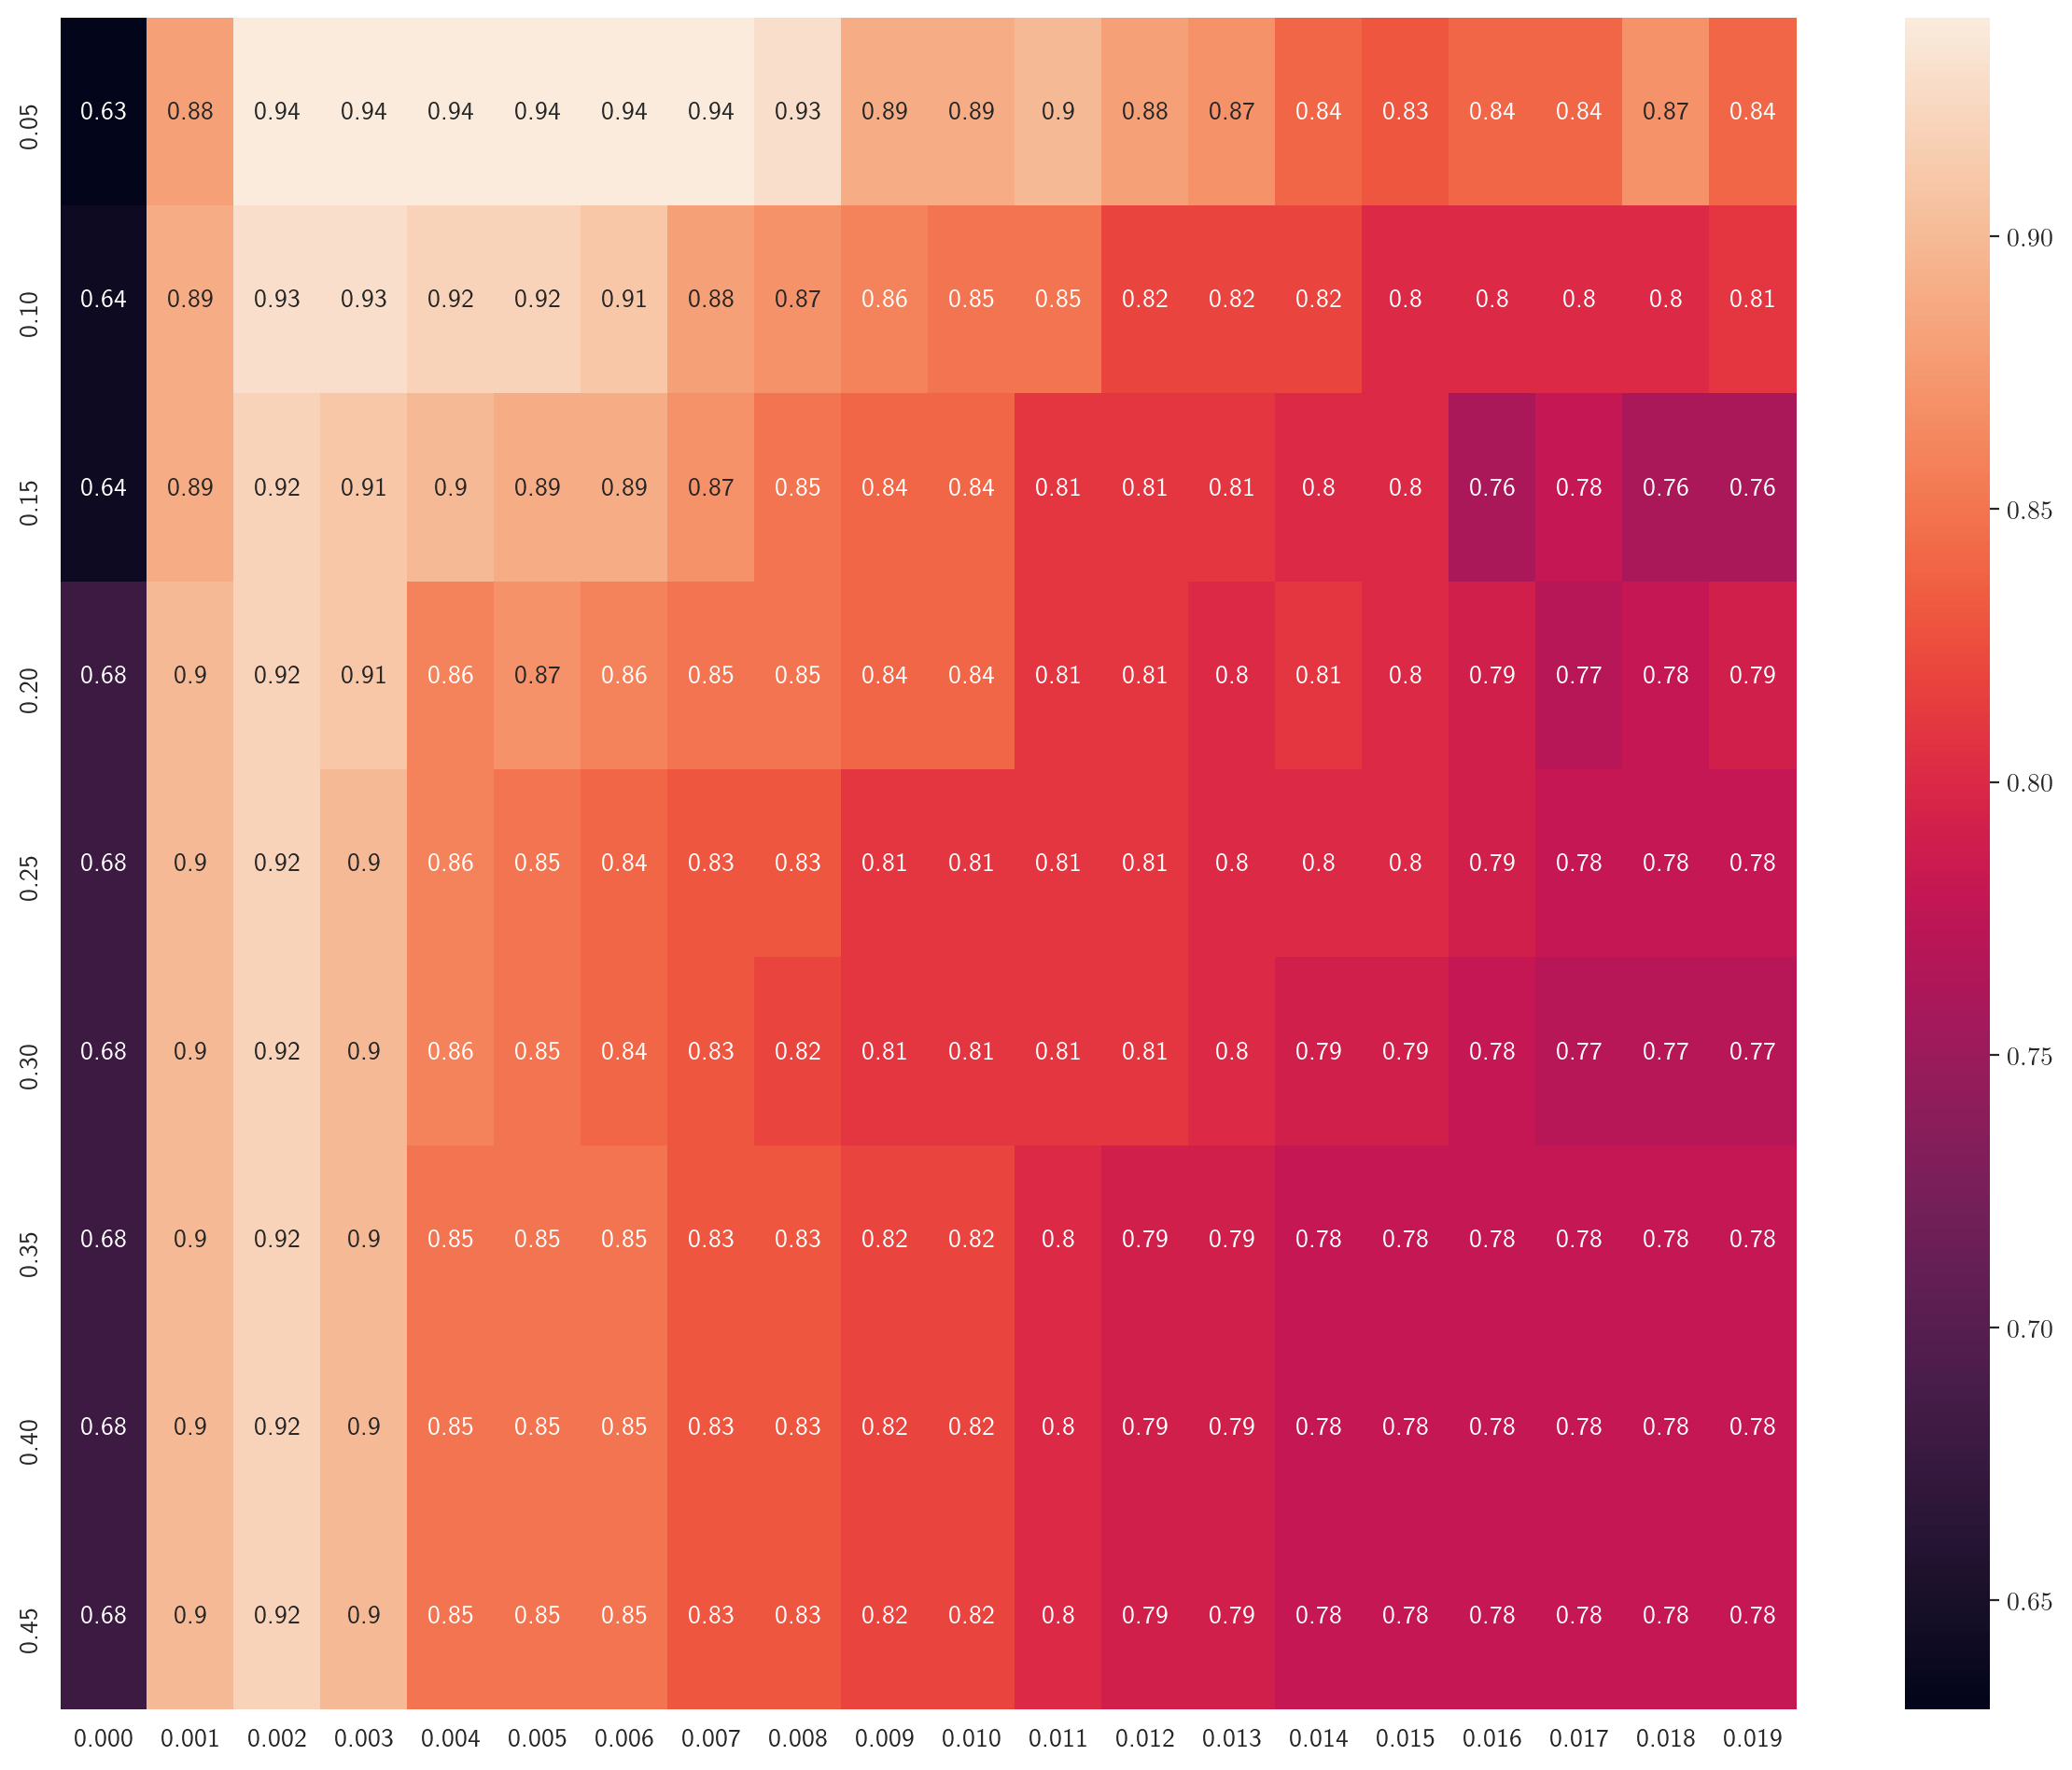

In [15]:
res_nbb_toplot = np.array([[ results[(min_df, max_df)][0] for min_df in range_mindf ] for max_df in range_maxdf ] )

fig = plt.figure(figsize=(15,12))
ax = sns.heatmap(res_nbb_toplot, annot=True)
ax.set_xticklabels(["%.3f" % min_df for min_df in range_mindf ])
ax.set_yticklabels(["%.2f" % max_df for max_df in range_maxdf ])
plt.show()

In [16]:
min_df, max_df = 0.0110, 0.200
vectorizer = CountVectorizer(min_df=min_df, max_df=max_df)
X_train_fulltext = np.array(Xtext_full)[train_set]
X_train = vectorizer.fit_transform([ " ".join(s) for s in np.array(Xtext)[train_set]])

N, M, K = X_train.shape[0], X_train.shape[1], len(classes)

## EM-алгоритм для кластеризации

In [17]:
print(N, M, K)
X = X_train.toarray()

1020 2628 5


In [18]:
def e_step(X, probs):
    z = np.matmul( X, np.log(probs).T )
    z = z - np.logaddexp.reduce(z, axis=1).reshape(-1, 1)
    return np.exp(z)

def m_step(X, z):
    probs = ( np.matmul(X.T, z) + np.ones((M, K)) ).T
    probs = np.divide( probs, np.sum(probs, axis=1).reshape(-1, 1) )
    return probs

def log_likelihood(X, z, probs):
    return np.sum(np.multiply( z, np.log(np.matmul( X, probs.T )) ))

In [19]:
probs = np.ones((K, M))
random_sample = np.random.choice(N, replace=False, size=5*K)
for k in range(K):
    probs[k] = probs[k] + np.sum(X[random_sample[5*k:5*k+5]], axis=0)
probs = np.divide( probs, np.sum(probs, axis=1).reshape(-1,1) )

In [20]:
old_l = 0
for iIter in range(100):
    new_z = e_step(X, probs)
    new_probs = m_step(X, new_z)
    l = log_likelihood(X, new_z, new_probs)
    print("Итерация %d:\t\t%.4f" % (iIter, l))
    if np.abs(l - old_l) < 1e-4:
        break
    z, probs, old_l = new_z, new_probs, l

Итерация 0:		-2397.0262
Итерация 1:		-2308.1632
Итерация 2:		-2280.8621
Итерация 3:		-2268.9305
Итерация 4:		-2262.7233
Итерация 5:		-2260.4860
Итерация 6:		-2257.9305
Итерация 7:		-2256.7136
Итерация 8:		-2254.6411
Итерация 9:		-2253.6123
Итерация 10:		-2253.0922
Итерация 11:		-2252.8153
Итерация 12:		-2251.9661
Итерация 13:		-2251.8893
Итерация 14:		-2251.4117
Итерация 15:		-2251.2543
Итерация 16:		-2251.0860
Итерация 17:		-2250.7830
Итерация 18:		-2250.7530
Итерация 19:		-2250.6274
Итерация 20:		-2250.4102
Итерация 21:		-2250.2058
Итерация 22:		-2250.2091
Итерация 23:		-2250.1733
Итерация 24:		-2250.1804
Итерация 25:		-2250.2589
Итерация 26:		-2250.3637
Итерация 27:		-2250.4144
Итерация 28:		-2250.4188
Итерация 29:		-2250.4111
Итерация 30:		-2250.4082
Итерация 31:		-2250.4075
Итерация 32:		-2250.4073
Итерация 33:		-2250.4073


In [21]:
for iCluster in range(5):
    print("=== Кластер %d ===\n" % iCluster)
    for iDoc in np.where(z[:, iCluster] > 0.99)[0][:10]:
        print(X_train_fulltext[iDoc][:300] + "\n\n")

=== Кластер 0 ===

22 ноября в бундестаге состоятся выборы  канцлера  германии  кандидатом на пост канцлера является председатель  хдс ангела меркель  она возглавит новое правительство германии, которое сформировано на основе, так называемой, большой коалиции  в коалицию входят сдпг и хдс/хсс вице-канцлером и одноврем


бмв с водородным двигателемфедеральный министр транспорта германии вольфганг тифензее объявил, что правительство выделяет 500 млн   на исследования в области технологии водородного  двигателя и технологии   это заявление тифензее сделал на открытии международной автомобильной ярмарки в е  500 млн  е


президент белоруссии александр лукашенко закрыл воздушное пространство своей страны для полётов ов западных авиакомпаний: они должны летать через балтийские страны или через украину возможно, мы тоже потеряем кое-что, но мы должны показать им нашу гордость, так говорит лукашенко в своём обращении к 


через 20 лет, после полёта первого а в е, состоялся первый полёт монголь

## pLSI

In [22]:
T = 10
Phi, Theta = np.random.random(size=(T, M)), np.random.random(size=(N, T))
Phi = np.divide( Phi, np.sum(Phi, axis=1).reshape(-1, 1) )
Theta = np.divide( Theta, np.sum(Theta, axis=1).reshape(-1, 1) )

In [23]:
def e_step(X, Phi, Theta):
    n_t, n_dt, n_wt = np.zeros(T), np.zeros((N, T)), np.zeros((M, T))
    for i in range(X.shape[0]):
        n_tdw = np.divide( np.multiply( np.multiply( Phi, Theta[i].reshape(-1, 1) ), X[i].reshape(1, -1)), np.matmul( Theta[i], Phi ).reshape(1, -1) )
        n_dt[i] = np.sum( n_tdw, axis=1 )
        n_t += np.sum( n_tdw, axis=1 )
        n_wt += n_tdw.T
    return n_wt, n_dt, n_t

def m_step(X, n_wt, n_dt, n_t):
    new_Phi = np.divide( n_wt, np.sum(n_wt, axis=0) ).T
    new_Theta = np.divide( n_dt, np.sum(X, axis=1).reshape(-1, 1) )
    return new_Phi, new_Theta

In [24]:
for iIter in range(100):
    n_wt, n_dt, n_t = e_step(X, Phi, Theta)
    new_Phi, new_Theta = m_step(X, n_wt, n_dt, n_t)
    
    residue = np.sum( (Phi - new_Phi) ** 2 ) + np.sum( (Theta - new_Theta) ** 2 )
    print("Итерация %d:\t\t%.4f" % (iIter, residue))
    if residue < 1e-3:
        break
    Phi, Theta = new_Phi, new_Theta

Итерация 0:		0.9447
Итерация 1:		0.8399
Итерация 2:		1.0456
Итерация 3:		1.4509
Итерация 4:		1.9794
Итерация 5:		2.4755
Итерация 6:		2.8010
Итерация 7:		2.8408
Итерация 8:		2.6064
Итерация 9:		2.2453
Итерация 10:		1.9100
Итерация 11:		1.6405
Итерация 12:		1.4285
Итерация 13:		1.2675
Итерация 14:		1.1454
Итерация 15:		1.0480
Итерация 16:		0.9691
Итерация 17:		0.9057
Итерация 18:		0.8520
Итерация 19:		0.7967
Итерация 20:		0.7400
Итерация 21:		0.6871
Итерация 22:		0.6361
Итерация 23:		0.5835
Итерация 24:		0.5249
Итерация 25:		0.4612
Итерация 26:		0.4023
Итерация 27:		0.3549
Итерация 28:		0.3171
Итерация 29:		0.2782
Итерация 30:		0.2507
Итерация 31:		0.2290
Итерация 32:		0.2117
Итерация 33:		0.1941
Итерация 34:		0.1771
Итерация 35:		0.1642
Итерация 36:		0.1523
Итерация 37:		0.1390
Итерация 38:		0.1244
Итерация 39:		0.1110
Итерация 40:		0.0988
Итерация 41:		0.0870
Итерация 42:		0.0786
Итерация 43:		0.0739
Итерация 44:		0.0722
Итерация 45:		0.0718
Итерация 46:		0.0687
Итерация 47:		0.0632
Ит

In [25]:
voc = [x[0] for x in sorted([(w,i) for w,i in vectorizer.vocabulary_.items()], key=lambda x: x[1]) ]

In [26]:
for t in range(T):
    word_probs = sorted([ (x, Phi[t, i]) for i,x in enumerate(voc) ], key=lambda x: x[1], reverse=True)
    print("Тема %d\n%s\n\n" % (t, "\n".join([ "%20s\t%.5f" % (x[0], x[1]) for x in word_probs[:10]])))

Тема 0
               фильм	0.01240
              премия	0.00957
               жизнь	0.00717
           известный	0.00649
             хороший	0.00642
               самый	0.00575
             русский	0.00574
                 мир	0.00553
             главный	0.00519
               когда	0.00516


Тема 1
            компания	0.01636
             система	0.00850
           экономика	0.00660
            развитие	0.00658
              проект	0.00592
             уровень	0.00589
                 млн	0.00551
            проблема	0.00478
          социальный	0.00461
               рынок	0.00459


Тема 2
                2009	0.01364
                  06	0.00823
                  15	0.00797
                2010	0.00738
               завод	0.00669
                  de	0.00668
                2008	0.00660
                июль	0.00659
                 com	0.00658
           александр	0.00631


Тема 3
                  d0	0.10620
                  d1	0.04125
           википедия	0.02515
         

## LDA

In [27]:
T = 10
Phi = np.random.random(size=(M, T))
Phi = np.divide( Phi, np.sum(Phi, axis=0).reshape(1, -1) )
Theta = np.random.random(size=(N, T))
Theta = np.divide( Theta, np.sum(Theta, axis=1).reshape(-1, 1) )

In [28]:
alpha = (2./T) * np.ones(T)

In [29]:
doc_lengths = np.sum(X, axis=1)
doc_words = []
for x in X:
    dw = []
    for i in np.where(x > 0)[0]:
        for _ in range(x[i]):
            dw.append(i)
    doc_words.append(np.array(dw))

In [30]:
def internal_em(doc_words, lPhi):
    Gamma = np.random.random(size=(N, T))
    Pi = [ np.zeros((n, T)) for n in doc_lengths ]
    for iIter in range(100):
        all_digammas = sp.special.digamma(Gamma) - sp.special.digamma(np.sum(Gamma, axis=1)).reshape(-1, 1)
        for i,dw in enumerate(doc_words):
            Pi[i] = lPhi[doc_words[i]] + all_digammas[i]
            Pi[i] = np.exp(Pi[i] - np.logaddexp.reduce(Pi[i], axis=1).reshape(-1, 1))
        new_Gamma = np.vstack( [alpha + np.sum(dpi, axis=0) for dpi in Pi] )
        residue = np.sum((new_Gamma-Gamma) ** 2)
        Gamma = new_Gamma
        if residue < 0.01:
            break
    return Gamma, Pi

In [31]:
def phi_m_step(doc_words, Pi):
    Phi = np.zeros((M, T))
    for i,dw in enumerate(doc_words):
        Phi[ dw ] += Pi[i]
    Phi = np.divide( Phi, np.sum(Phi, axis=0).reshape(1, -1) )
    return Phi

In [32]:
for iIter in range(20):
    lPhi = np.log(Phi)
    Gamma, Pi = internal_em(doc_words, lPhi)
    new_Phi = phi_m_step(doc_words, Pi)
    residue = np.sum( (new_Phi - Phi) ** 2)
    Phi = new_Phi
    print("Итерация %d\t\t%.7f" % (iIter, residue))
    if residue < 1e-5:
        break

Итерация 0		0.0042780
Итерация 1		0.0004403
Итерация 2		0.0004427
Итерация 3		0.0004501
Итерация 4		0.0004021
Итерация 5		0.0003067
Итерация 6		0.0002609
Итерация 7		0.0002242
Итерация 8		0.0001904
Итерация 9		0.0001788
Итерация 10		0.0001626
Итерация 11		0.0001479
Итерация 12		0.0001493
Итерация 13		0.0001439
Итерация 14		0.0001486
Итерация 15		0.0001334
Итерация 16		0.0001216
Итерация 17		0.0001193
Итерация 18		0.0001096
Итерация 19		0.0001281


In [33]:
for t in range(T):
    word_probs = sorted([ (x, Phi[i, t]) for i,x in enumerate(voc) ], key=lambda x: x[1], reverse=True)
    print("Тема %d\n%s\n\n" % (t, "\n".join([ "%20s\t%.5f" % (x[0], x[1]) for x in word_probs[:10]])))

Тема 0
               акция	0.00520
              митинг	0.00491
            участник	0.00482
              москва	0.00439
               лидер	0.00432
        политический	0.00428
           оппозиция	0.00411
              выборы	0.00407
             участие	0.00385
              партия	0.00379


Тема 1
            компания	0.00760
              доллар	0.00658
           составить	0.00483
                 com	0.00408
               рынок	0.00392
               самый	0.00390
             миллион	0.00388
             система	0.00372
          составлять	0.00369
             больший	0.00366


Тема 2
           отношение	0.00509
              вопрос	0.00475
                дело	0.00465
         государство	0.00397
         иностранный	0.00395
             сторона	0.00390
        политический	0.00360
             заявить	0.00356
              против	0.00342
              заявил	0.00336


Тема 3
       экономический	0.00405
            развитие	0.00367
            компания	0.00356
         

In [34]:
beta = (50./M) * np.ones(M)

In [35]:
Gamma = np.random.random(size=(N, T))
Pi = [ np.zeros((n, T)) for n in doc_lengths ]
Lambda = np.random.random(size=(M, T))
for iIter in range(200):
    Phi = np.divide( Lambda, np.sum(Lambda, axis=0).reshape(1, -1) )
    lPhi = np.log(Phi)
    all_digammas = sp.special.digamma(Gamma) - sp.special.digamma(np.sum(Gamma, axis=1)).reshape(-1, 1)
    for i,dw in enumerate(doc_words):
        Pi[i] = lPhi[doc_words[i]] + all_digammas[i]
        Pi[i] = np.exp(Pi[i] - np.logaddexp.reduce(Pi[i], axis=1).reshape(-1, 1))
    new_Gamma = np.vstack( [alpha + np.sum(dpi, axis=0) for dpi in Pi] )
    new_Lambda = np.zeros((M, T)) + beta.reshape(-1, 1)
    for i,dw in enumerate(doc_words):
        new_Lambda[ dw, : ] += Pi[i]
    residue = ( np.sum((new_Gamma-Gamma) ** 2), np.sum((new_Lambda-Lambda) ** 2) )
    print("Итерация %d\t\t%.5f\t%.5f" % (iIter, residue[0], residue[1]))
    Gamma, Lambda = new_Gamma, new_Lambda
    if residue[0] < 1e-2 and residue[1] < 1e-2:
        break

Итерация 0		24585720.41402	679142.41300
Итерация 1		28662.74222	7904.59763
Итерация 2		33868.17479	6210.92527
Итерация 3		47237.32690	5332.13163
Итерация 4		64624.65787	4820.42191
Итерация 5		82535.72615	4516.90238
Итерация 6		96595.48316	4343.69420
Итерация 7		106021.73462	4235.71240
Итерация 8		114021.26287	4119.31838
Итерация 9		126930.81499	3926.75434
Итерация 10		149276.61391	3641.86245
Итерация 11		173939.68345	3282.28522
Итерация 12		194713.02824	2880.50503
Итерация 13		216832.69867	2481.76900
Итерация 14		238601.94299	2128.79935
Итерация 15		249848.53784	1829.91075
Итерация 16		244007.19405	1574.65403
Итерация 17		222966.13289	1354.87115
Итерация 18		193811.42511	1167.93050
Итерация 19		163416.35897	1013.92655
Итерация 20		135797.35222	889.43944
Итерация 21		112348.05460	787.24135
Итерация 22		92980.80156	700.90136
Итерация 23		76740.71761	621.03514
Итерация 24		63336.51015	549.60700
Итерация 25		52476.24751	486.29134
Итерация 26		43645.26698	426.83185
Итерация 27		36475.56658	

In [36]:
Phi = np.divide( Lambda, np.sum(Lambda, axis=0).reshape(1, -1) )
for t in range(T):
    word_probs = sorted([ (x, Phi[i, t]) for i,x in enumerate(voc) ], key=lambda x: x[1], reverse=True)
    print("Тема %d\n%s\n\n" % (t, "\n".join([ "%20s\t%.5f" % (x[0], x[1]) for x in word_probs[:10]])))

Тема 0
            владимир	0.00409
              партия	0.00405
              сергей	0.00378
              выборы	0.00360
              москва	0.00357
           александр	0.00302
          московский	0.00299
                  рф	0.00297
          состояться	0.00295
               путин	0.00292


Тема 1
              выборы	0.00922
              партия	0.00757
       президентский	0.00455
            кандидат	0.00452
               голос	0.00441
                пост	0.00396
        политический	0.00362
       парламентский	0.00351
              бывший	0.00344
             премьер	0.00338


Тема 2
           произойти	0.00520
               около	0.00477
          находиться	0.00476
                 под	0.00432
              данные	0.00427
           погибнуть	0.00413
               город	0.00406
               место	0.00373
               через	0.00371
               центр	0.00355


Тема 3
            сообщать	0.00417
             решение	0.00398
                 тем	0.00361
         